# Reverse engineering Mac OS (And iPhone) screen time SQLite db

Based on:
1. [Knowledge is Power! Using the macOS/iOS knowledgeC.db Database to Determine Precise User and Application Usage](https://www.mac4n6.com/blog/2018/8/5/knowledge-is-power-using-the-knowledgecdb-database-on-macos-and-ios-to-determine-precise-user-and-application-usage)
2. [Knowledge is Power II – A Day in the Life of My iPhone using knowledgeC.db](https://www.mac4n6.com/blog/2018/9/12/knowledge-is-power-ii-a-day-in-the-life-of-my-iphone-using-knowledgecdb)


In [2]:
import sqlite3
import os
import pandas as pd

In [3]:
DB_PATH = os.path.join(os.path.expanduser("~"), "Application Support", "Knowledge", "knowledgeC.db")
DB_PATH_DUMP = os.path.join(os.path.expanduser("~"), "knowledgeC_dump20240328.db")

In [4]:
def query_and_fetchall(db_path:str, query:str) -> pd.DataFrame:
    conn = sqlite3.connect(db_path)
    return pd.read_sql_query(query, conn)


### Listing all the tables

In [5]:
q_all_table_names = "SELECT name FROM sqlite_master WHERE type='table'"
df_tables = query_and_fetchall(DB_PATH_DUMP, q_all_table_names)

df_tables

,name
0,ZADDITIONCHANGESET
1,ZCONTEXTUALCHANGEREGISTRATION
2,ZCONTEXTUALKEYPATH
3,ZCUSTOMMETADATA
4,Z_4EVENT
5,ZDELETIONCHANGESET
6,ZHISTOGRAM
7,ZHISTOGRAMVALUE
8,ZKEYVALUE
9,ZOBJECT


### See all /app/usage events (note that data is a bit different from the post)

In [6]:
q_app_usage = """
SELECT
  datetime(ZOBJECT.ZCREATIONDATE+978307200,'UNIXEPOCH', 'LOCALTIME') as "event_datetime", 
  CASE ZOBJECT.ZSTARTDAYOFWEEK 
      WHEN "1" THEN "Sunday"
      WHEN "2" THEN "Monday"
      WHEN "3" THEN "Tuesday"
      WHEN "4" THEN "Wednesday"
      WHEN "5" THEN "Thursday"
      WHEN "6" THEN "Friday"
      WHEN "7" THEN "Saturday"
  END "event_dow",
  ZOBJECT.ZSECONDSFROMGMT/3600 AS "event_gtm_offset",
  datetime(ZOBJECT.ZSTARTDATE+978307200,'UNIXEPOCH', 'LOCALTIME') as "event_start", 
  datetime(ZOBJECT.ZENDDATE+978307200,'UNIXEPOCH', 'LOCALTIME') as "event_end", 
  (ZOBJECT.ZENDDATE-ZOBJECT.ZSTARTDATE) as "event_duration",
  ZOBJECT.ZSTREAMNAME event_type, 
  ZOBJECT.ZVALUESTRING event_description,
  ZOBJECT.ZHASCUSTOMMETADATA has_custom_metadadata, 
  ZOBJECT.ZHASSTRUCTUREDMETADATA has_structured_metadata, 
  ZOBJECT.ZSTRING event_zstring, 
  ZOBJECT.ZVALUECLASS event_valueclass, 
  ZSOURCE.ZDEVICEID event_source_dev_id 
FROM ZOBJECT
  LEFT JOIN ZSOURCE ON ZOBJECT.ZSOURCE  = ZSOURCE.Z_PK
  LEFT JOIN ZSTRUCTUREDMETADATA on ZOBJECT.ZSTRUCTUREDMETADATA = ZSTRUCTUREDMETADATA.Z_PK
WHERE ZSTREAMNAME = "/app/usage" 
ORDER BY "START"
"""

In [7]:
df_app_usage = query_and_fetchall(DB_PATH_DUMP, q_app_usage)
df_app_usage[1000:15300]

,event_datetime,event_dow,event_gtm_offset,event_start,event_end,event_duration,event_type,event_description,has_custom_metadadata,has_structured_metadata,event_zstring,event_valueclass,event_source_dev_id
1000,2024-03-12 19:28:10,Tuesday,-3,2024-03-12 19:28:04,2024-03-12 19:28:09,5,/app/usage,com.google.Chrome,0,1,None,1,None
1001,2024-03-12 19:28:16,Tuesday,-3,2024-03-12 19:28:13,2024-03-12 19:28:16,3,/app/usage,com.google.Chrome,0,1,None,1,None
1002,2024-03-12 19:28:28,Tuesday,-3,2024-03-12 19:28:22,2024-03-12 19:28:28,6,/app/usage,com.google.Chrome,0,1,None,1,None
1003,2024-03-12 19:28:48,Tuesday,-3,2024-03-12 19:28:42,2024-03-12 19:28:48,6,/app/usage,com.google.Chrome,0,1,None,1,None
1004,2024-03-12 19:29:13,Tuesday,-3,2024-03-12 19:29:09,2024-03-12 19:29:13,4,/app/usage,com.google.Chrome,0,1,None,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10361,2024-03-24 13:43:12,Sunday,-3,2024-03-24 13:43:00,2024-03-24 13:43:12,12,/app/usage,com.pagerduty.PagerDuty,0,1,None,1,380D4F66-0F14-52B1-85FB-B8B9188119BA
10362,2024-03-24 13:44:51,Sunday,-3,2024-03-24 13:44:38,2024-03-24 13:44:51,13,/app/usage,com.pagerduty.PagerDuty,0,1,None,1,380D4F66-0F14-52B1-85FB-B8B9188119BA
10363,2024-03-24 14:53:44,Sunday,-3,2024-03-24 14:53:25,2024-03-24 14:53:44,19,/app/usage,com.pagerduty.PagerDuty,0,1,None,1,380D4F66-0F14-52B1-85FB-B8B9188119BA
10364,2024-03-25 13:55:14,Monday,-3,2024-03-25 13:54:25,2024-03-25 13:55:14,49,/app/usage,com.pagerduty.PagerDuty,0,1,None,1,380D4F66-0F14-52B1-85FB-B8B9188119BA


In [8]:
q_all_events = """
SELECT
  ZOBJECT.Z_PK AS event_id,
  datetime(ZOBJECT.ZCREATIONDATE+978307200,'UNIXEPOCH', 'LOCALTIME') AS event_datetime, 
  CASE ZOBJECT.ZSTARTDAYOFWEEK 
      WHEN "1" THEN "Sunday"
      WHEN "2" THEN "Monday"
      WHEN "3" THEN "Tuesday"
      WHEN "4" THEN "Wednesday"
      WHEN "5" THEN "Thursday"
      WHEN "6" THEN "Friday"
      WHEN "7" THEN "Saturday"
  END AS event_dow,
  ZOBJECT.ZSECONDSFROMGMT/3600 AS event_gtm_offset,
  datetime(ZOBJECT.ZSTARTDATE+978307200,'UNIXEPOCH', 'LOCALTIME') AS event_start, 
  datetime(ZOBJECT.ZENDDATE+978307200,'UNIXEPOCH', 'LOCALTIME') AS event_end, 
  (ZOBJECT.ZENDDATE-ZOBJECT.ZSTARTDATE) AS event_duration,
  ZOBJECT.ZSTREAMNAME AS event_type, 
  ZOBJECT.ZVALUESTRING AS event_description,

  ZOBJECT.ZHASCUSTOMMETADATA AS has_custom_md, 
  ZCUSTOMMETADATA.ZNAME AS custom_md_name,
  ZCUSTOMMETADATA.ZDOUBLEVALUE AS custom_md_double_value,
  ZCUSTOMMETADATA.ZSTRINGVALUE AS custom_md_string_value,
  ZOBJECT.ZHASSTRUCTUREDMETADATA AS has_structured_md, 
  ZSTRUCTUREDMETADATA.Z_DKINTENTMETADATAKEY__INTENTVERB AS structured_md_intent_verb, 
  ZSTRUCTUREDMETADATA.Z_DKINTENTMETADATAKEY__INTENTCLASS AS structured_md_intent_class, 
  ZSTRUCTUREDMETADATA.Z_DKINTENTMETADATAKEY__DERIVEDINTENTIDENTIFIER AS structured_md_derived_intent_id,
  ZSTRUCTUREDMETADATA.Z_CDENTITYMETADATAKEY__NAME AS structured_md_entity_name,
  ZSTRUCTUREDMETADATA.Z_DKNOTIFICATIONUSAGEMETADATAKEY__BUNDLEID AS structured_md_bundle_id,
  HEX(ZSTRUCTUREDMETADATA.Z_DKINTENTMETADATAKEY__SERIALIZEDINTERACTION) AS structured_md_serialized_interaction,
  --ZOBJECT.ZSTRING AS event_zstring, 
  ZOBJECT.ZVALUECLASS AS event_valueclass, 
  ZSOURCE.ZDEVICEID AS source_dev_id ,
  ZSOURCE.ZGROUPID as source_group_id,
  ZSOURCE.ZITEMID AS source_item_id,
  ZSOURCE.ZBUNDLEID AS  source_boundle_id,
  CURRENT_TIMESTAMP AS extraction_dt
FROM ZOBJECT
  LEFT JOIN ZSOURCE ON ZOBJECT.ZSOURCE  = ZSOURCE.Z_PK
  LEFT JOIN ZSTRUCTUREDMETADATA ON ZOBJECT.ZSTRUCTUREDMETADATA = ZSTRUCTUREDMETADATA.Z_PK
  LEFT JOIN Z_4EVENT ON ZOBJECT.Z_PK = Z_4EVENT.Z_11EVENT
  LEFT JOIN ZCUSTOMMETADATA ON Z_4EVENT.Z_4CUSTOMMETADATA = ZCUSTOMMETADATA.Z_PK
"""

In [9]:
df_all_events = query_and_fetchall(DB_PATH_DUMP, q_all_events)

In [10]:
import duckdb

con = duckdb.connect("../io/targets/20240328_ddb_test.duckdb")
duckdb.sql("CREATE TABLE all_events_stg AS SELECT * FROM df_all_events")


### Now testing abstracted functions

In [11]:
import sys


base_path = os.getcwd().rsplit(os.path.sep, 2)[0]
relative_path = 'python_projects/mac_and_iphone_screentime_exporter'
module_path = os.path.join(base_path, relative_path)
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/andy/notaarguello/notaarguello_repo/python_projects/mac_and_iphone_screentime_exporter


In [12]:
from mac_and_iphone_screentime_exporter.services import backup_sqlite_db

In [13]:
backup_sqlite_db(
    sqlite_orig_path=DB_PATH_DUMP,
    duckdb_dest_path="../io/targets/20240402_ddb_test.duckdb",
    duckdb_dest_tbl="knowledgeCdb_all_events",
    query=q_all_events,
    incremental_on=("event_id", "extraction_dt"))

In [14]:
con = duckdb.connect("../io/targets/20240402_ddb_test.duckdb")

In [15]:
con.sql("""SELECT DISTINCT event_type FROM knowledgeCdb_all_events""").df()

,event_type
0,/app/mediaUsage
1,/app/webUsage
2,/device/isLocked
3,/portrait/entity
4,/knowledge-sync-addition-window/380D4F66-0F14-...
5,/knowledge-sync-deletion-bookmark/5D5D6990-C67...
6,/knowledge-sync-addition-window/5D5D6990-C67E-...
7,/notification/usage
8,/app/intents
9,/portrait/topic


In [16]:
con.sql("""
        SELECT 
            event_start::DATE event_date, 
            event_description, 
            CASE WHEN source_dev_id IS NULL THEN 'MAC' ELSE 'IPHONE' END device,
            sum(event_duration)/60 screen_time_minutes
        FROM knowledgeCdb_all_events 
        WHERE event_type = '/app/usage'
        GROUP BY 1, 2, 3
        ORDER BY 1, 4 DESC, 3"""
).df()[100:110]

,event_date,event_description,device,screen_time_minutes
100,2024-03-08,com.todoist.ios,IPHONE,2.500000
101,2024-03-08,md.obsidian,IPHONE,1.983333
102,2024-03-08,com.apple.Terminal,MAC,1.716667
103,2024-03-08,com.apple.mobiletimer,IPHONE,1.050000
104,2024-03-08,com.reddit.Reddit,IPHONE,0.483333
105,2024-03-08,com.apple.finder,MAC,0.350000
106,2024-03-08,com.apple.MobileSMS,IPHONE,0.300000
107,2024-03-08,com.todoist.mac.Todoist,MAC,0.266667
108,2024-03-08,com.google.calendar,IPHONE,0.150000
109,2024-03-08,com.apple.PosterBoard,IPHONE,0.116667


In [17]:
con.sql("""
    COPY
        (SELECT 
            event_description, 
            CASE WHEN source_dev_id IS NULL THEN 'MAC' ELSE 'IPHONE' END device_type,
            sum(event_duration)/60 screen_time_minutes
        FROM knowledgeCdb_all_events 
        WHERE event_type = '/app/usage'
        GROUP BY 1, 2
        ORDER BY 3 DESC
        )
    TO "../io/targets/20240406_event_types.csv"
        """
)

In [18]:
con.sql("""
WITH events AS (
    SELECT 
        event_start::DATE AS event_date, 
        event_description, 
        CASE WHEN source_dev_id IS NULL THEN 'MAC' ELSE 'IPHONE' END AS device_type,
        event_duration
    FROM knowledgeCdb_all_events 
    WHERE event_type = '/app/usage'
)

SELECT
    events.event_date,
    COALESCE(categories.event_category, 'OTHER') AS event_category,
    events.device_type,
    sum(events.event_duration)/60 AS screen_time_minutes
FROM events
    LEFT JOIN read_csv("../io/inputs/20240406_event_description_conf.csv") categories
        ON categories.event_description = events.event_description AND (categories.device_type = events.device_type OR categories.device_type IS NULL)
GROUP BY
    1, 2, 3
""").df()[10:15]

,event_date,event_category,device_type,screen_time_minutes
10,2024-03-04,Social network apps,IPHONE,65.650000
11,2024-03-14,Social network apps,IPHONE,275.900000
12,2024-03-25,Social network apps,IPHONE,160.983333
13,2024-03-23,Social network apps,IPHONE,252.183333
14,2024-03-28,Social network apps,IPHONE,211.133333


In [19]:
from mac_and_iphone_screentime_exporter.services.knowledgec_full_update import knowledgec_full_update

In [20]:
knowledgec_full_update(
    sqlite_orig_path=DB_PATH_DUMP,
    duckdb_dest_path="../io/targets/20240406_ddb_test.duckdb"
)

In [21]:
con = duckdb.connect("../io/targets/20240406_ddb_test.duckdb")
con.sql("SELECT table_name FROM duckdb_tables;").df()

,table_name
0,daily_summary
1,knowledgeCdb_all_events
2,screen_time_by_category_daily_totals
3,screen_time_by_category_hourly_totals


In [94]:
df = con.sql("""
    SELECT strftime(event_date, '%m-%d %a') event_date, event_hour, SUM(total_screen_time) AS total_screen_time
    FROM screen_time_by_category_hourly_totals 
    WHERE device_type = 'IPHONE' 
    GROUP BY 1, 2
    ORDER BY event_date DESC"""
).df()

#df['event_date'] = df['event_date'].dt.strftime('%Y-%m-%d')

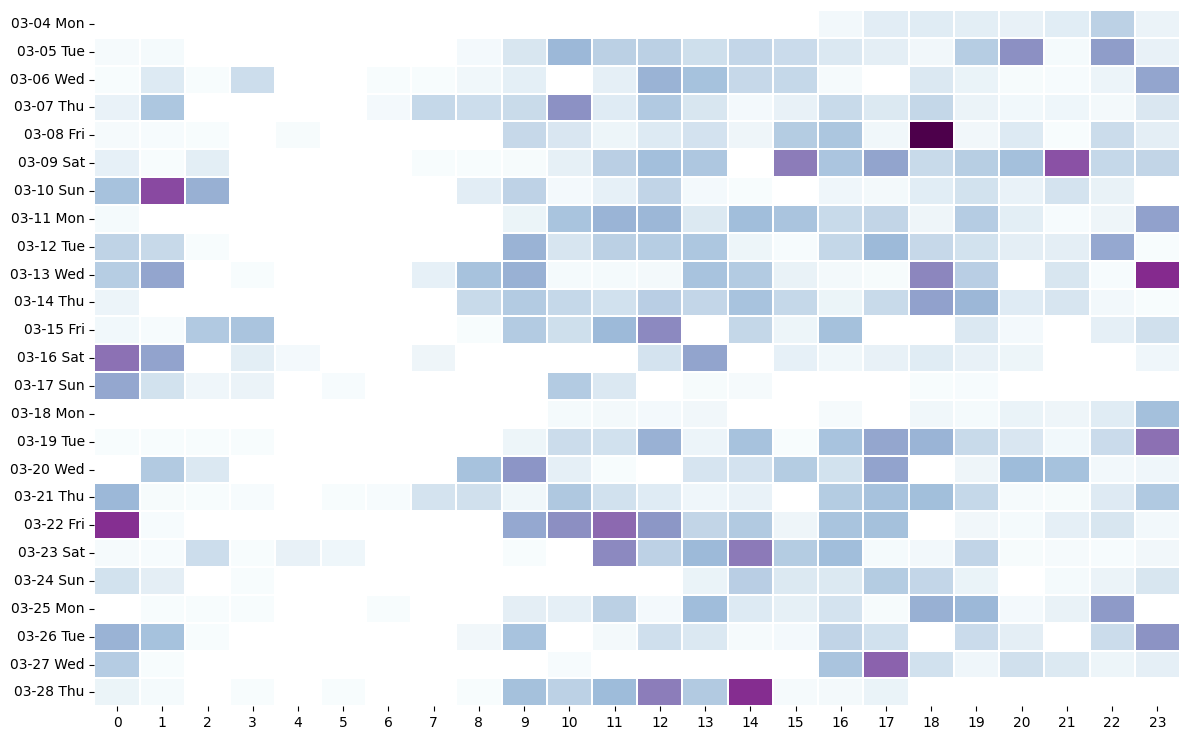

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt


pivot_df = df.pivot(index='event_date', columns='event_hour', values='total_screen_time')

plt.figure(figsize=(12, 7.5))
sns.heatmap(pivot_df, cmap="BuPu", linewidths=.01, annot=False, cbar=False)
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.savefig("../io/20240406 Heatmap.png")